# Práctico Mabwiser

Adaptado de los tutoriales disponibles en: https://github.com/fidelity/mabwiser/tree/master/examples

## Reinforcement Learning

Un agente de RL busca tomar acciones que logren maximizar la ganancia acumulativa.

![RL setup](https://github.com/bamine/recsys-summer-school/raw/12e57cc4fd1cb26164d2beebf3ca29ebe2eab960/notebooks/images/rl-setup.png)


## Exploration vs. Exploitation

Se busca encontrar un balance entre la exploration (decidir tomar una acción para ganar conocimiento) y exploitation (decidir la acción que se calcula que tendrá la mejor ganancia).

![texto alternativo](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)

## Importar paquetes necesarios

In [15]:
!pip install mabwiser
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.preprocessing import StandardScaler

from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy

import random
from mabwiser.simulator import Simulator

from time import time

## Problema con contexto:

Una plataforma de comercio virtual cuenta con 5 _ads_ y quiere determinar cuál de estos generará mayor _revenue_ para un usuario en específico. Para esto, se cuenta con información histórica de _revenues_ obtenidos por otros usuarios en distintos _ads_ junto con la información de la edad, la razón de clicks y si cada usuario es subscriptor o no.

In [16]:
# Arms
ads = [1, 2, 3, 4, 5]

# Historical data of ad decisions with corresponding revenues and context information
train_df = pd.DataFrame({'ad': [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
                         'revenues': [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
                         'age': [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
                         'click_rate': [0.2, 0.6, 0.99, 0.68, 0.15, 0.23, 0.75, 0.17,
                                        0.33, 0.65, 0.56, 0.22, 0.19, 0.11, 0.83],
                         'subscriber': [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]}
                        )

# Test data to for new prediction
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
test_df_revenue = pd.Series([7, 13])

# Scale the training and test data
scaler = StandardScaler()
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

In [17]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# KNearest context policy with k equals to 5 and ucb1 learning with alpha of 1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Learn from previous ads shown and revenues generated
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predict the next best ad to show
prediction = knearest.predict(test)

# Expectation of each ad based on learning from past ad revenues
expectations = knearest.predict_expectations(test)

# Results
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Online update of model
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Updating of the model with new arm
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


### Actividad 1: 
Suponga que a este mismo usuario, se le presenta el nuevo _ad_, $6$, obteniendo un revenue de $40$. Usando el método _partial\_fit_ simule este caso e imprima las nuevas expectations. Comente los resultados obtenidos.

In [18]:
knearest.partial_fit(decisions=[6, 6], rewards=pd.Series([40, 40]), contexts=test)

prediction = knearest.predict(test)
expectations = knearest.predict_expectations(test)

print("KNearest: ", prediction, " ", expectations)

KNearest:  [6, 6]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 9.242653222492628, 6: 42.24265322249263}, {1: 19.0857953014744, 2: 22.242653222492628, 3: 0, 4: 0, 5: 7.242653222492627, 6: 42.24265322249263}]


El nuevo *ad* **6** es la expectativa prevista por lejos de los otros *ad*, debido a que ha tenido un revenue considerablemente más alto para los usuarios.

## Problema sin contexto:

El sitio ahora quiere elegir entre dos posibles opciones de diseño para su _homepage_. Para esto tiene datos históricos del revenue aportado por cada diseño, pero no cuenta con ningún dato acerca de los usuarios.

In [19]:
# Arms
options = [1, 2]

# Historical data of layouts decisions and corresponding rewards
layouts = [1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1]
revenues = [10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10]

In [20]:
###################################
# Epsilon Greedy Learning Policy
###################################

# Epsilon Greedy learning policy with random exploration set to 15%
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

# Learn from previous layouts decisions and revenues generated
greedy.fit(decisions=layouts, rewards=revenues)

# Predict the next best layouts decision
prediction = greedy.predict()

# Expected revenues of each layouts learnt from historical data based on epsilon greedy policy
expectations = greedy.predict_expectations()

# Results
print("Epsilon Greedy: ", prediction, " ", expectations)
# assert(prediction == 1)

# Additional historical data becomes available which allows _online learning
additional_layouts = [1, 2, 1, 2]
additional_revenues = [0, 12, 7, 19]

# Online updating of the model
greedy.partial_fit(additional_layouts, additional_revenues)

Epsilon Greedy:  1   {1: 10.875, 2: 14.714285714285714}


### Actividad 2:
Suponga que en un experimento online, se le muestra a un usuario ambos diseños y el _revenue_ obtenido es exactamente el estimado por el agente. ¿Qué esperaría que pase al actualizar el modelo? Simule este caso en $5$ iteraciones, imprimiendo las expectations. Comente los resultados observados.

In [21]:
#KNearest
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

prediction = knearest.predict(test)
expectations = knearest.predict_expectations(test)

print("KNearest 0 : ", prediction, " ", expectations)

for i in range(5):
  knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)
  
  prediction = knearest.predict(test)
  expectations = knearest.predict_expectations(test)

  print("KNearest", (i + 1), ": ", prediction, " ", expectations)

print("")

# Epsilon Greedy
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

greedy.fit(decisions=layouts, rewards=revenues)

prediction = greedy.predict()
expectations = greedy.predict_expectations()

print("Epsilon Greedy 0 : ", prediction, " ", expectations)

for i in range(5):
  greedy.partial_fit(list(expectations.keys()), list(expectations.values()))

  prediction = greedy.predict()
  expectations = greedy.predict_expectations()

  print("Epsilon Greedy", (i + 1), ": ", prediction, " ", expectations)

KNearest 0 :  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]
KNearest 1 :  [1, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 10.0857953014744}, {1: 19.0857953014744, 2: 17.5857953014744, 3: 0, 4: 0, 5: 7.242653222492627}]
KNearest 2 :  [1, 2]   [{1: 12.294796441705099, 2: 11.242653222492628, 3: 0, 4: 0, 5: 9.242653222492628}, {1: 17.2947964417051, 2: 22.242653222492628, 3: 0, 4: 0, 5: 7.242653222492627}]
KNearest 3 :  [1, 2]   [{1: 11.121326611246314, 2: 0, 3: 0, 4: 0, 5: 9.242653222492628}, {1: 14.5857953014744, 2: 18.0857953014744, 3: 0, 4: 0, 5: 7.242653222492627}]
KNearest 4 :  [1, 2]   [{1: 10.621326611246314, 2: 0, 3: 0, 4: 0, 5: 9.242653222492628}, {1: 14.5857953014744, 2: 16.628129775038435, 3: 0, 4: 0, 5: 0}]
KNearest 5 :  [5, 1]   [{1: 8.121326611246314, 2: 0, 3: 0, 4: 0, 5: 9.242653222492628}, {1: 14.5857953014744, 2: 

En el caso de KNN, el valor esperado va variando según las prediciones anteriores, mientras que en Epsilon Greedy éstas se mantienen siempre iguales.

* Learning policies:
 * Epsilon Greedy
 * LinTS
 * LinUCB
 * Popularity
 * Random
 * Softmax
 * Thompson Sampling (TS)
 * Upper Confidence Bound (UCB1)

* Neighborhood Policies
 * Clusters
 * K-Nearest
 * LSH Nearest
 * Radius
 * TreeBandit

## Simulación:

Vamos a simular un multi-armed bandits para un dataset aleatorio con $1000$ entradas de datos y comparar los rendimientos de cada learning-policy:

In [22]:
size = 1000

decisions = [random.randint(0, 2) for _ in range(size)]
rewards = [random.randint(0, 1000) for _ in range(size)]
contexts = [[random.random() for _ in range(50)] for _ in range(size)]

In [23]:
####################################
# Different Bandits for Simulation
####################################

print('Starting simulation 1\n')


def binarize(decision, reward):

    return reward >= 500

n_jobs=2
contextual_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize),
                                            NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15),
                                         NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs))]

context_free_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), n_jobs=n_jobs)),
                     ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), n_jobs=n_jobs)),
                     ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize), n_jobs=n_jobs)),
                     ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15), n_jobs=n_jobs)),
                     ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), n_jobs=n_jobs))]

Starting simulation 1



2021-10-26 01:43:34,677 INFO Simulation Parameters
2021-10-26 01:43:34,677 INFO Simulation Parameters
2021-10-26 01:43:34,682 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f1eda8e9390>), ('UCB1', <mabwiser.mab.MAB object at 0x7f1ed9922050>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f1eda8e9550>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f1eda8e9910>), ('Softmax', <mabwiser.mab.MAB object at 0x7f1eda8e9610>)]
2021-10-26 01:43:34,682 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f1eda8e9390>), ('UCB1', <mabwiser.mab.MAB object at 0x7f1ed9922050>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f1eda8e9550>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f1eda8e9910>), ('Softmax', <mabwiser.mab.MAB object at 0x7f1eda8e9610>)]
2021-10-26 01:43:34,686 INFO 	 scaler: None
2021-10-26 01:43:34,686 INFO 	 scaler: None
2021-10-26 01:43:34,692 INFO 	 test_size: 0.5
2021-10-26 01:43:34,692 INFO 	 test_size: 0.5
2021-10-26 01:43:34,697 INFO 	 is_

Complete 0.012309741973876954 minutes


Random
Worst Case Scenario: {0: {'count': 269, 'sum': 45125, 'min': 6, 'max': 989, 'mean': 167.75092936802974, 'std': 278.623930847915}, 1: {'count': 231, 'sum': 34587, 'min': 6, 'max': 1000, 'mean': 149.72727272727272, 'std': 272.23154947383597}}
Average Case Scenario: {0: {'count': 269, 'sum': 134086.62499999997, 'min': 6.0, 'max': 989.0, 'mean': 498.4632899628252, 'std': 169.3856479336706}, 1: {'count': 231, 'sum': 114604.81142857145, 'min': 6.0, 'max': 1000.0, 'mean': 496.1247247990106, 'std': 154.87129631609352}}
Best Case Scenario: {0: {'count': 269, 'sum': 222425, 'min': 6, 'max': 997, 'mean': 826.8587360594795, 'std': 295.154326918604}, 1: {'count': 231, 'sum': 199583, 'min': 6, 'max': 1000, 'mean': 863.995670995671, 'std': 267.30289089176574}}



UCB1
Worst Case Scenario: {0: {'count': 500, 'sum': 86595, 'min': 6, 'max': 989, 'mean': 173.19, 'std': 275.569609899205}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std':

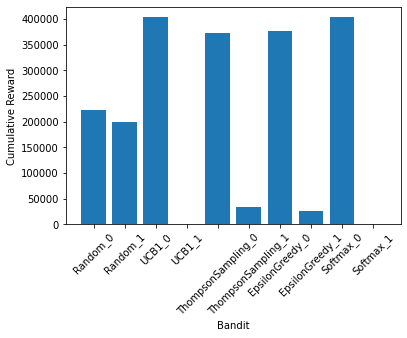

In [24]:
####################################
# Context-Free Simulation
####################################
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=0, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name])

    print('\n\n')

sim.plot('max', True) 
# Vamos a plotear el best case scenario para todos los bandidos utilizados. El parámetro True indica que en el plot se va a plotear por separado cada "brazo"

### Actividad 3: Simulación "on-line" con contexto.

Basándose en el código anterior, vamos a repetir este experimento para los bandidos con contexto definidos anteriormente. Recuerde que los datos de contextos deben ser escalados, por lo que debe cambiar el parámetro scaler.

Esta simulación, a diferencia de la anterior, simulará un agente que se va actualizando de manera "on-line", en donde en cada iteración, los agentes reciben $100$ datos y en base a estos, actualizan sus políticas. Para hacer esto, solo debe modificar el parámetro de batch-size. Comente sus resultados

2021-10-26 01:43:35,818 INFO Simulation Parameters
2021-10-26 01:43:35,818 INFO Simulation Parameters
2021-10-26 01:43:35,818 INFO Simulation Parameters
2021-10-26 01:43:35,827 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f1ed9922ed0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f1ed9922b90>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f1edebd7850>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f1eda91b8d0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f1eda91b790>)]
2021-10-26 01:43:35,827 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f1ed9922ed0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f1ed9922b90>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f1edebd7850>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f1eda91b8d0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f1eda91b790>)]
2021-10-26 01:43:35,827 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f1ed9922ed0>), ('UCB1', <mabwiser.mab.MAB object at 0x7f1ed9922b90>), ('Thompson

Complete 0.2146298885345459 minutes


Random
Worst Case Scenario: {0: {'count': 273, 'sum': 45353, 'min': 6, 'max': 987, 'mean': 166.12820512820514, 'std': 267.8661747827619}, 1: {'count': 227, 'sum': 34735, 'min': 6, 'max': 981, 'mean': 153.01762114537445, 'std': 265.97596799058005}}
Average Case Scenario: {0: {'count': 273, 'sum': 128939.48470262249, 'min': 6.0, 'max': 987.0, 'mean': 472.30580477151096, 'std': 169.00261217240222}, 1: {'count': 227, 'sum': 112726.76759840152, 'min': 18.0, 'max': 981.0, 'mean': 496.59368986079966, 'std': 154.95178519940046}}
Best Case Scenario: {0: {'count': 273, 'sum': 218461, 'min': 6, 'max': 997, 'mean': 800.2234432234433, 'std': 307.531751063128}, 1: {'count': 227, 'sum': 193592, 'min': 18, 'max': 1000, 'mean': 852.8281938325991, 'std': 273.6986694744207}}



UCB1
Worst Case Scenario: {0: {'count': 151, 'sum': 25573, 'min': 6, 'max': 989, 'mean': 169.35761589403972, 'std': 273.01763144119417}, 1: {'count': 349, 'sum': 58210, 'min': 6, 'max': 1000, 

2021-10-26 01:43:48,900 INFO NumExpr defaulting to 2 threads.
2021-10-26 01:43:48,900 INFO NumExpr defaulting to 2 threads.
2021-10-26 01:43:48,900 INFO NumExpr defaulting to 2 threads.


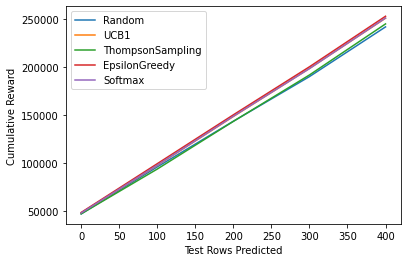

In [25]:
start = time()
sim = Simulator(contextual_mabs, decisions, rewards, contexts=contexts,
                scaler=StandardScaler(), test_size=0.5, is_ordered=False, batch_size=100, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    # Como esta simulación es online, se debe específicar que imprima el valor 'total'
    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name]['total'])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name]['total'])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name]['total'])

    print('\n\n')

sim.plot('avg', False)
# Como buscamos ahora maximizar el revenue, no separaremos los resultados por brazo, sino que se graficará de manera conjunta el revenue promedio obtenido por cada agente.

El Epsilon Greedy presenta los mejores resultados en la simulación con contexto. Sin embargo, se puede observar que se obtiene un reward acumulado menor (alrededor de 250.000) que el mejor caso posible para varias de las policies sin contexto (entre 350.000 y 400.000).